In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

# read in solar forecast data
path = 'https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/Modeling_Session_2/'
solar_values_read = pd.read_csv(path+'pred_solar_values.csv')
solar_values = round(solar_values_read.yhat,3)
solar_values.reset_index(drop = True, inplace = True)

# read in demaind data, where total demand is a fixed building demand and
# an estimated demand based on a proposed schedule for the building
schedule = pd.read_csv(path+'schedule_demand.csv')
avg_building = pd.read_csv(path+'building_demand.csv')
total_demand = schedule.sched_demand + avg_building.build_demand
print(f"Total Solar Generation: {solar_values.sum()} \nTotal Demand: {total_demand.sum()}")

# create data for batteries, including capity, efficency and initial charges
# also define time periods,
batteries = ["Battery0", "Battery1"]
capacity = {"Battery0": 60, "Battery1": 80} # in Kw
p_loss = {"Battery0": 0.95, "Battery1": 0.9} # proportion
initial = {"Battery0": 0, "Battery1": 0} # in kW
time_periods = range(len(solar_values_read))

Total Solar Generation: 4939.172 
Total Demand: 5250.6


In [62]:
m = gp.Model()
# max charge / discharge 20kw per single period
MAX_FLOW = 20

# DECISION VARIABLES
flow_in = m.addVars(batteries, time_periods, name="flow_in") 
flow_out = m.addVars(batteries, time_periods, name="flow_out")
grid = m.addVars(time_periods, name='grid') # energy acquistata
state = m.addVars(batteries, time_periods, name="state") # quanta energia in ciascuna batteria 
gen = m.addVars(time_periods, name="gen") # qtà di energia solare usata nel tempo t
zwitch = m.addVars(batteries, time_periods, vtype=GRB.BINARY, name='zwitch') # se una batteria sta caricando o scaricando


In [63]:
# CONSTRAINTS
m.addConstrs((gen[t]+grid[t]+gp.quicksum(flow_out[b,t]-flow_in[b,t]*p_loss[b] for b in batteries) == total_demand[t] for t in time_periods), name='power_balance')
m.addConstrs((state[b,0] == flow_in[b,0]*p_loss[b] - flow_out[b,0] for b in batteries), name='initial_state')
m.addConstrs((state[b,t] == state[b,t-1] + flow_in[b,t]*p_loss[b] -  flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name='subsequent_states') # skippo primo time period
m.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail");
# flowin >= 0 or flowout >= 0
# flowin <= z1*C
# flowout <= z2*C
m.addConstrs((flow_in[b,t] <= zwitch[b,t]*MAX_FLOW for b in batteries for t in time_periods), name = "to_charge")
m.addConstrs((flow_out[b,t] <= (1-zwitch[b,t])*MAX_FLOW for b in batteries for t in time_periods), name = "or_not_to_charge")

# max charge per ciascuna battery in ciascun istante di tempo
for b, t in state:
    state[b,t].UB = capacity[b]

In [64]:
# OBJECTIVE 
# read in estimated price of electricity for each time period
avg_price = pd.read_csv(path+'expected_price.csv')
price = avg_price.price

# define a linear expression for total energy purchased from the grid
total_grid = grid.sum()
# define a linear expression for total cost
total_cost = gp.quicksum(avg_price.price[t]*grid[t] for t in time_periods)


m.setObjective(total_grid, GRB.MINIMIZE) # MINIMIZZO ACQUISTO DALLA GRID

In [65]:
m.optimize()

results = pd.DataFrame([[round(v,2) for v in [total_cost.getValue(),total_grid.getValue()]]],
                       columns = ['Cost','GridAmount']
                       )

results

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0xaa31bb6a
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 5250.6000000
Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Found heuristic solution: objective 4986.0960000
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 1.281678e+03, 603 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

,Cost,GridAmount
0,788.44,1281.68


Periods Battery0 charges: 50
Periods Battery1 charges: 27
Periods Battery0 discharges: 49
Periods Battery1 discharges: 20
Periods at Battery0 at Full Capacity: 18
Periods at Battery1 at Full Capacity: 11
Proportion of time periods where electrity is purchaced from the grid: 0.433


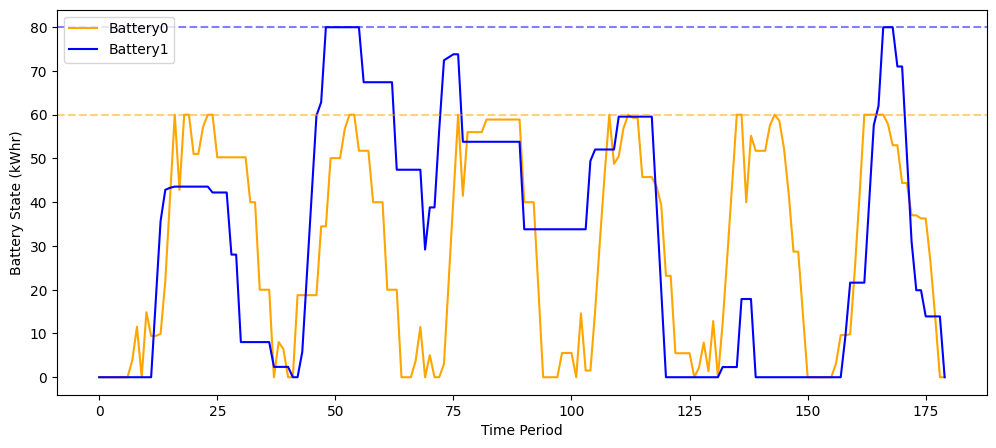

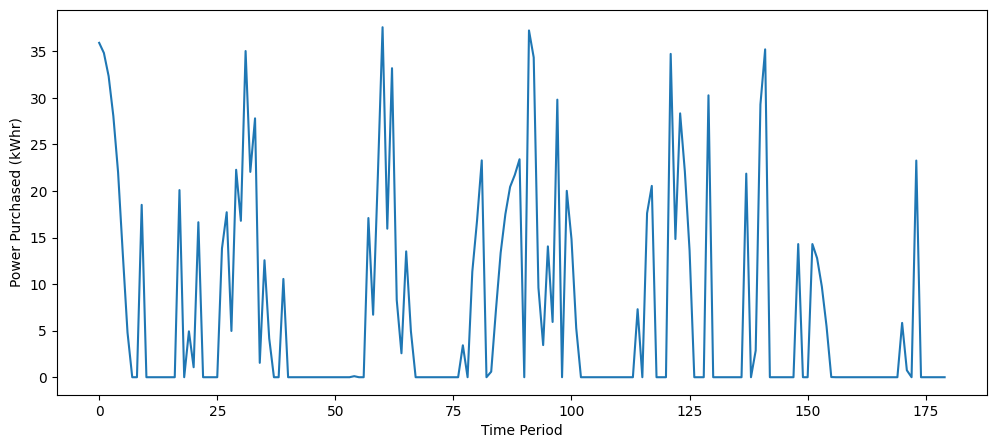

In [66]:
sol_in = pd.Series(m.getAttr('X',flow_in))
sol_out = pd.Series(m.getAttr('X',flow_out))
sol_level = pd.Series(m.getAttr('X',state))

print(f"Periods Battery0 charges: {sum(sol_in['Battery0'] > 0)}")
print(f"Periods Battery1 charges: {sum(sol_in['Battery1'] > 0)}")
print(f"Periods Battery0 discharges: {sum(sol_out['Battery0'] > 0)}")
print(f"Periods Battery1 discharges: {sum(sol_out['Battery1'] > 0)}")

plt.figure(figsize=(12,5))
s0, = plt.plot(sol_level['Battery0'], c = 'orange')
s1, = plt.plot(sol_level['Battery1'], c = 'blue')
plt.ylabel('Battery State (kWhr)')
plt.xlabel('Time Period')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level['Battery1']==capacity['Battery1'])}");

sol_grid = pd.Series(m.getAttr('X',grid))
plt.figure(figsize=(12,5))
plt.plot(sol_grid)
plt.ylabel('Power Purchased (kWhr)')
plt.xlabel('Time Period');
print(f"Proportion of time periods where electrity is purchaced from the grid: {round(sum(sol_grid > 0)/len(sol_grid),3)}")

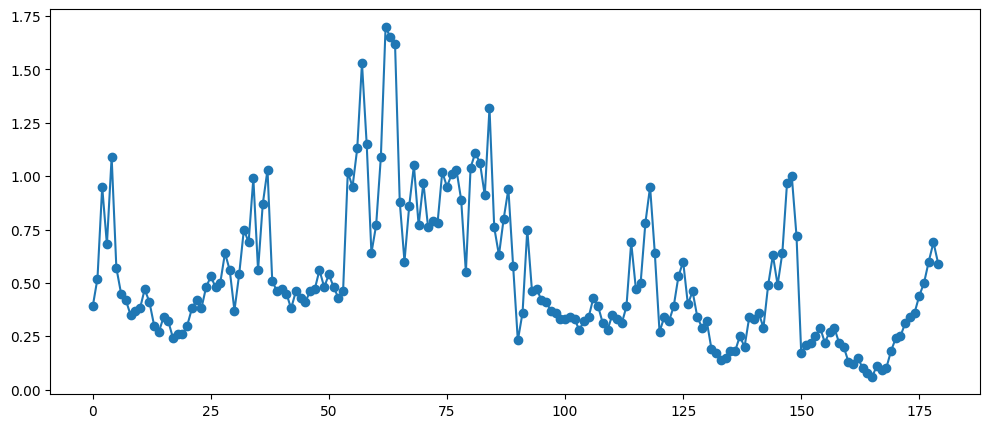

In [67]:
avg_price = pd.read_csv(path+'expected_price.csv')
# avg_price = pd.read_csv('expected_price.csv')
plt.figure(figsize=(12,5))
plt.plot(avg_price.index, avg_price.price, '-o');

In [68]:
m.setObjective(total_cost, GRB.MINIMIZE) # MINIMIZZO COSTO TOTALE

In [69]:
m.optimize()

results = pd.concat([results, 
                     pd.DataFrame([[round(v,2) for v in [total_cost.getValue(),total_grid.getValue()]]], columns = ['Cost','GridAmount'])
                     ],
                    ignore_index=True
                    )

results

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x66bddde2
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

MIP start from previous solve produced solution with objective 607.227 (0.01s)
Loaded MIP start from previous solve with objective 607.227

Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 6.019761e+02, 769 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Nod

,Cost,GridAmount
0,788.44,1281.68
1,601.98,1317.69


Periods at Battery0 at Full Capacity: 26
Periods at Battery1 at Full Capacity: 18


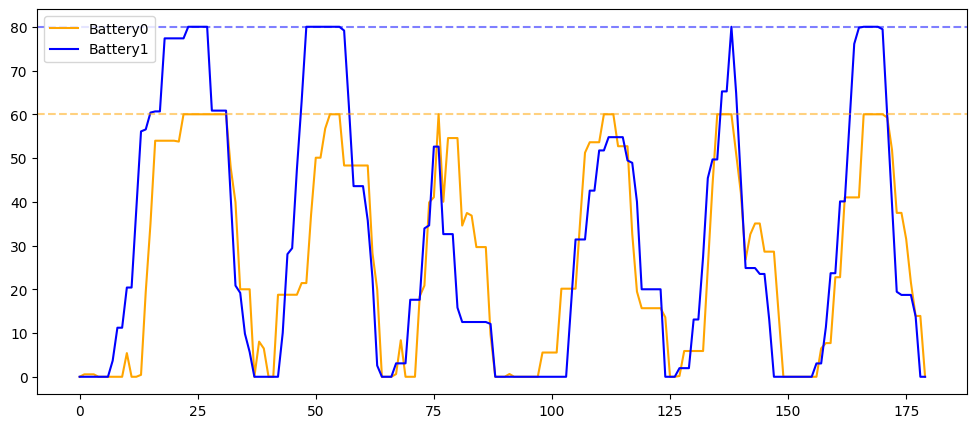

In [70]:
sol_level_cost = pd.Series(m.getAttr('X',state))
plt.figure(figsize=(12,5))
plt.plot(sol_level_cost['Battery0'], c ='orange')
plt.plot(sol_level_cost['Battery1'], c ='blue')
plt.legend([s0,s1],["Battery0", "Battery1"])
plt.axhline(y=capacity['Battery0'], c='orange', linestyle='--', alpha = 0.5)
plt.axhline(y=capacity['Battery1'], c='blue', linestyle='--', alpha = 0.5)
print(f"Periods at Battery0 at Full Capacity: {sum(sol_level_cost['Battery0']==capacity['Battery0'])}")
print(f"Periods at Battery1 at Full Capacity: {sum(sol_level_cost['Battery1']==capacity['Battery1'])}");